# Whole-Cohort Model Comparison: Krakencoder vs Raw Ensemble

This notebook compares test accuracies across:
1. Original Krakencoder latent space
2. Sex fine-tuned Krakencoder latent space  
3. Raw connectivity ensembles (all connectivity types)

All models use 100 repetitions with train_test_ratio train/test split.

## 1. Setup and Imports

In [49]:
# sex age diff
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 2. Load Krakencoder Results

In [ ]:
# Paths to krakencoder results
kraken_dir = Path('/home/out_log/results_HCPdata_Kraken/wholecohort/krakencoder')

# Load original krakencoder
train_test_ratio = 50
orig_file = kraken_dir / 'original' / f'wholecohort_encoded_pred_split0328_True_train{train_test_ratio}_logistic.mat'
orig_data = scipy.io.loadmat(orig_file, simplify_cells=True)

# Load sex fine-tuned krakencoder
sex_file = kraken_dir / 'sex_finetuned' / f'wholecohort_encoded_pred_split0328_True_train{train_test_ratio}_logistic.mat'
sex_data = scipy.io.loadmat(sex_file, simplify_cells=True)

print("Krakencoder data loaded!")
print(f"Fusion types: {list(orig_data.keys())}")

Krakencoder data loaded!
Fusion types: ['__header__', '__version__', '__globals__', 'fusion', 'fusionFC', 'fusionSC']


## 3. Extract Test Accuracies from Krakencoder

In [51]:
# Function to extract test accuracies
def extract_accuracies(data, model_name):
    """
    Extract test accuracies for all fusion types
    """
    results = {}
    
    for fusion_type in ['fusion', 'fusionFC', 'fusionSC']:
        if fusion_type in data:
            test_acc = data[fusion_type]['test_accuracy'].flatten()
            results[fusion_type] = {
                'mean': np.mean(test_acc),
                'std': np.std(test_acc),
                'min': np.min(test_acc),
                'max': np.max(test_acc),
                'median': np.median(test_acc),
                'accuracies': test_acc
            }
    
    return results

# Extract accuracies
orig_results = extract_accuracies(orig_data, 'Original Krakencoder')
sex_results = extract_accuracies(sex_data, 'Sex Fine-tuned Krakencoder')


print("ORIGINAL KRAKENCODER RESULTS")
for fusion_type, stats in orig_results.items():
    print(f"\n{fusion_type}: Mean accuracy: {stats['mean']:.4f} ± {stats['std']:.4f}")


print("SEX FINE-TUNED KRAKENCODER RESULTS")
for fusion_type, stats in sex_results.items():
    print(f"\n{fusion_type}: Mean accuracy: {stats['mean']:.4f} ± {stats['std']:.4f}")

ORIGINAL KRAKENCODER RESULTS

fusion: Mean accuracy: 0.9051 ± 0.0124

fusionFC: Mean accuracy: 0.8810 ± 0.0137

fusionSC: Mean accuracy: 0.8425 ± 0.0184
SEX FINE-TUNED KRAKENCODER RESULTS

fusion: Mean accuracy: 0.9288 ± 0.0121

fusionFC: Mean accuracy: 0.8922 ± 0.0120

fusionSC: Mean accuracy: 0.8895 ± 0.0115


## 4. Load Raw Ensemble Results

In [ ]:
# Paths to ensemble results
ensemble_dir = Path('/home/out_log/results_HCPdata_Kraken/wholecohort/logistic_regression_ensemble')

# Define connectivity types
connectivity_types = [
    'SCifod2act_coco439_volnormicv',
    'SCsdstream_coco439_volnormicv',
    'SCifod2act_shen268_volnormicv',
    'SCsdstream_shen268_volnormicv',
    'SCifod2act_fs86_volnormicv',
    'SCsdstream_fs86_volnormicv',
    'FCcorr_coco439_hpf',
    'FCcorr_coco439_hpfgsr',
    'FCpcorr_coco439_hpf',
    'FCcorr_shen268_hpf',
    'FCcorr_shen268_hpfgsr',
    'FCpcorr_shen268_hpf',
    'FCcorr_fs86_hpf',
    'FCcorr_fs86_hpfgsr',
    'FCpcorr_fs86_hpf'
]

# Load ensemble results
ensemble_results = {}
missing_files = []

for contype in connectivity_types:
    file_path = ensemble_dir / f"{contype}_wholecohort_stratifiedCV_split0328_True_train{train_test_ratio}.mat"
    if file_path.exists():
        data = scipy.io.loadmat(file_path, simplify_cells=True)
        test_acc = data['test_accuracy'].flatten()
        ensemble_results[contype] = {
            'mean': np.mean(test_acc),
            'std': np.std(test_acc),
            'min': np.min(test_acc),
            'max': np.max(test_acc),
            'median': np.median(test_acc),
            'accuracies': test_acc
        }
    else:
        missing_files.append(contype)

print(f"Loaded {len(ensemble_results)} connectivity types")
if missing_files:
    print(f"\nMissing {len(missing_files)} files:")
    for f in missing_files:
        print(f"  - {f}")

Loaded 15 connectivity types


## 5. Compute Combined Ensemble Across All 15 Connectivity Types

In [53]:
print("COMPUTING COMBINED ENSEMBLE (All 15 Connectivity Types)")

# Load test predictions for each connectivity type
ensemble_predictions = {}
n_reps = 100

for contype in connectivity_types:
    file_path = ensemble_dir / f"{contype}_wholecohort_stratifiedCV_split0328_True_train{train_test_ratio}.mat"
    if file_path.exists():
        data = scipy.io.loadmat(file_path, simplify_cells=True)
        ensemble_predictions[contype] = data['test_result']

print(f"Loaded predictions from {len(ensemble_predictions)} connectivity types")

# Compute combined ensemble accuracy for each repetition
combined_accuracies = []

for rep in range(n_reps):
    # Collect predictions from all connectivity types for this repetition
    all_preds = []
    y_true = None
    
    for contype in ensemble_predictions.keys():
        y_test_rep, y_pred_rep = ensemble_predictions[contype][rep]
        all_preds.append(y_pred_rep)
        
        # Store ground truth (same across all connectivity types)
        if y_true is None:
            y_true = y_test_rep
    
    # Convert to array (shape: n_connectivity_types x n_test_samples)
    all_preds = np.array(all_preds)
    
    # Majority voting: for each test sample, take the most common prediction
    from scipy import stats
    ensemble_pred = stats.mode(all_preds, axis=0, keepdims=False)[0]
    
    # Calculate accuracy
    acc = np.mean(ensemble_pred == y_true)
    combined_accuracies.append(acc)

combined_accuracies = np.array(combined_accuracies)

# Store combined ensemble results
ensemble_results['ALL_15_COMBINED'] = {
    'mean': np.mean(combined_accuracies),
    'std': np.std(combined_accuracies),
    'min': np.min(combined_accuracies),
    'max': np.max(combined_accuracies),
    'median': np.median(combined_accuracies),
    'accuracies': combined_accuracies
}

print(f"\nCombined Ensemble (All 15 types with majority voting):")
print(f"  Mean accuracy: {ensemble_results['ALL_15_COMBINED']['mean']:.4f} ± {ensemble_results['ALL_15_COMBINED']['std']:.4f}")
print(f"  Median: {ensemble_results['ALL_15_COMBINED']['median']:.4f}")
print(f"  Range: [{ensemble_results['ALL_15_COMBINED']['min']:.4f}, {ensemble_results['ALL_15_COMBINED']['max']:.4f}]")
print(f"\nNumber of connectivity types used: {len(ensemble_predictions)}")

COMPUTING COMBINED ENSEMBLE (All 15 Connectivity Types)
Loaded predictions from 15 connectivity types

Combined Ensemble (All 15 types with majority voting):
  Mean accuracy: 0.9225 ± 0.0106
  Median: 0.9236
  Range: [0.8974, 0.9475]

Number of connectivity types used: 15


## 6. Ensemble Summary Statistics

In [54]:
print("RAW ENSEMBLE RESULTS")

# Group by modality
sc_types = [k for k in ensemble_results.keys() if k.startswith('SC')]
fc_types = [k for k in ensemble_results.keys() if k.startswith('FC')]

print(f"\nStructural Connectivity (SC): {len(sc_types)} types")
for contype in sorted(sc_types):
    stats = ensemble_results[contype]
    print(f"  {contype:40s}: {stats['mean']:.4f} ± {stats['std']:.4f}")

print(f"\nFunctional Connectivity (FC): {len(fc_types)} types")
for contype in sorted(fc_types):
    stats = ensemble_results[contype]
    print(f"  {contype:40s}: {stats['mean']:.4f} ± {stats['std']:.4f}")

# Combined ensemble
if 'ALL_15_COMBINED' in ensemble_results:
    print("COMBINED ENSEMBLE (All 15 Connectivity Types - Majority Voting)")
    stats = ensemble_results['ALL_15_COMBINED']
    print(f"  Mean accuracy: {stats['mean']:.4f} ± {stats['std']:.4f}")
    print(f"  Median: {stats['median']:.4f}")
    print(f"  Range: [{stats['min']:.4f}, {stats['max']:.4f}]")


RAW ENSEMBLE RESULTS

Structural Connectivity (SC): 6 types
  SCifod2act_coco439_volnormicv           : 0.8252 ± 0.0156
  SCifod2act_fs86_volnormicv              : 0.7681 ± 0.0176
  SCifod2act_shen268_volnormicv           : 0.8505 ± 0.0137
  SCsdstream_coco439_volnormicv           : 0.8118 ± 0.0150
  SCsdstream_fs86_volnormicv              : 0.7453 ± 0.0221
  SCsdstream_shen268_volnormicv           : 0.8409 ± 0.0144

Functional Connectivity (FC): 9 types
  FCcorr_coco439_hpf                      : 0.8553 ± 0.0169
  FCcorr_coco439_hpfgsr                   : 0.8590 ± 0.0160
  FCcorr_fs86_hpf                         : 0.7863 ± 0.0169
  FCcorr_fs86_hpfgsr                      : 0.7817 ± 0.0196
  FCcorr_shen268_hpf                      : 0.8345 ± 0.0159
  FCcorr_shen268_hpfgsr                   : 0.8319 ± 0.0143
  FCpcorr_coco439_hpf                     : 0.8740 ± 0.0172
  FCpcorr_fs86_hpf                        : 0.7950 ± 0.0178
  FCpcorr_shen268_hpf                     : 0.8538 ± 0.0154
C

## 7. Compute FC-only and SC-only Ensembles

In [55]:
from scipy import stats as scipy_stats
print("COMPUTING MODALITY-SPECIFIC ENSEMBLES")

# Separate connectivity types by modality
fc_types = [ct for ct in connectivity_types if ct.startswith('FC')]
sc_types = [ct for ct in connectivity_types if ct.startswith('SC')]

print(f"\nFC types ({len(fc_types)}): {fc_types}")
print(f"SC types ({len(sc_types)}): {sc_types}")

# Function to compute ensemble for a subset of connectivity types
def compute_subset_ensemble(conn_types, predictions_dict, n_reps=100):
    combined_accuracies = []
    
    for rep in range(n_reps):
        all_preds = []
        y_true = None
        
        for contype in conn_types:
            if contype in predictions_dict:
                y_test_rep, y_pred_rep = predictions_dict[contype][rep]
                all_preds.append(y_pred_rep)
                
                if y_true is None:
                    y_true = y_test_rep
        
        # Majority voting
        all_preds = np.array(all_preds)
        ensemble_pred = scipy_stats.mode(all_preds, axis=0, keepdims=False)[0]
        
        # Calculate accuracy
        acc = np.mean(ensemble_pred == y_true)
        combined_accuracies.append(acc)
    
    return np.array(combined_accuracies)

# Compute FC ensemble
fc_accuracies = compute_subset_ensemble(fc_types, ensemble_predictions, n_reps)
ensemble_results['FC_9_COMBINED'] = {
    'mean': np.mean(fc_accuracies),
    'std': np.std(fc_accuracies),
    'min': np.min(fc_accuracies),
    'max': np.max(fc_accuracies),
    'median': np.median(fc_accuracies),
    'accuracies': fc_accuracies
}

# Compute SC ensemble
sc_accuracies = compute_subset_ensemble(sc_types, ensemble_predictions, n_reps)
ensemble_results['SC_6_COMBINED'] = {
    'mean': np.mean(sc_accuracies),
    'std': np.std(sc_accuracies),
    'min': np.min(sc_accuracies),
    'max': np.max(sc_accuracies),
    'median': np.median(sc_accuracies),
    'accuracies': sc_accuracies
}

print(f"\nFC Ensemble (9 types):")
print(f"  Mean accuracy: {ensemble_results['FC_9_COMBINED']['mean']:.4f} ± {ensemble_results['FC_9_COMBINED']['std']:.4f}")

print(f"\nSC Ensemble (6 types):")
print(f"  Mean accuracy: {ensemble_results['SC_6_COMBINED']['mean']:.4f} ± {ensemble_results['SC_6_COMBINED']['std']:.4f}")

COMPUTING MODALITY-SPECIFIC ENSEMBLES

FC types (9): ['FCcorr_coco439_hpf', 'FCcorr_coco439_hpfgsr', 'FCpcorr_coco439_hpf', 'FCcorr_shen268_hpf', 'FCcorr_shen268_hpfgsr', 'FCpcorr_shen268_hpf', 'FCcorr_fs86_hpf', 'FCcorr_fs86_hpfgsr', 'FCpcorr_fs86_hpf']
SC types (6): ['SCifod2act_coco439_volnormicv', 'SCsdstream_coco439_volnormicv', 'SCifod2act_shen268_volnormicv', 'SCsdstream_shen268_volnormicv', 'SCifod2act_fs86_volnormicv', 'SCsdstream_fs86_volnormicv']

FC Ensemble (9 types):
  Mean accuracy: 0.8860 ± 0.0146

SC Ensemble (6 types):
  Mean accuracy: 0.8758 ± 0.0136


## 8. Grouped Bar Plot: Ensemble vs Krakencoders

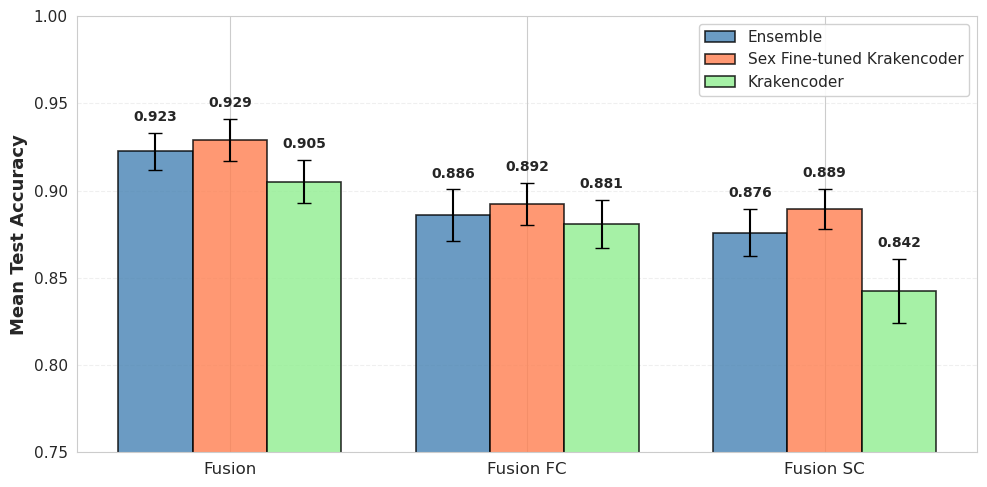

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for grouped bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Define groups
groups = ['Fusion', 'Fusion FC', 'Fusion SC']
x_pos = np.arange(len(groups))
width = 0.25  # Width of bars

# Data for each bar in each group
# Group 1: All
ensemble_all_mean = ensemble_results['ALL_15_COMBINED']['mean']
ensemble_all_std = ensemble_results['ALL_15_COMBINED']['std']
sex_fusion_mean = sex_results['fusion']['mean']
sex_fusion_std = sex_results['fusion']['std']
orig_fusion_mean = orig_results['fusion']['mean']
orig_fusion_std = orig_results['fusion']['std']

# Group 2: FC
ensemble_fc_mean = ensemble_results['FC_9_COMBINED']['mean']
ensemble_fc_std = ensemble_results['FC_9_COMBINED']['std']
sex_fusionfc_mean = sex_results['fusionFC']['mean']
sex_fusionfc_std = sex_results['fusionFC']['std']
orig_fusionfc_mean = orig_results['fusionFC']['mean']
orig_fusionfc_std = orig_results['fusionFC']['std']

# Group 3: SC
ensemble_sc_mean = ensemble_results['SC_6_COMBINED']['mean']
ensemble_sc_std = ensemble_results['SC_6_COMBINED']['std']
sex_fusionsc_mean = sex_results['fusionSC']['mean']
sex_fusionsc_std = sex_results['fusionSC']['std']
orig_fusionsc_mean = orig_results['fusionSC']['mean']
orig_fusionsc_std = orig_results['fusionSC']['std']

# Organize data
ensemble_means = [ensemble_all_mean, ensemble_fc_mean, ensemble_sc_mean]
ensemble_stds = [ensemble_all_std, ensemble_fc_std, ensemble_sc_std]

sex_kraken_means = [sex_fusion_mean, sex_fusionfc_mean, sex_fusionsc_mean]
sex_kraken_stds = [sex_fusion_std, sex_fusionfc_std, sex_fusionsc_std]

orig_kraken_means = [orig_fusion_mean, orig_fusionfc_mean, orig_fusionsc_mean]
orig_kraken_stds = [orig_fusion_std, orig_fusionfc_std, orig_fusionsc_std]

# Create bars
bars1 = ax.bar(x_pos - width, ensemble_means, width, yerr=ensemble_stds, label='Ensemble', color='steelblue', 
               alpha=0.8, capsize=5, edgecolor='black', linewidth=1.2)

bars2 = ax.bar(x_pos, sex_kraken_means, width, yerr=sex_kraken_stds, label='Sex Fine-tuned Krakencoder', color='coral',
               alpha=0.8, capsize=5, edgecolor='black', linewidth=1.2)

bars3 = ax.bar(x_pos + width, orig_kraken_means, width, yerr=orig_kraken_stds, label='Krakencoder', color='lightgreen',
               alpha=0.8, capsize=5, edgecolor='black', linewidth=1.2)

# Add value labels on bars
def add_value_labels(bars, means, stds):
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.005,  f'{mean:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1, ensemble_means, ensemble_stds)
add_value_labels(bars2, sex_kraken_means, sex_kraken_stds)
add_value_labels(bars3, orig_kraken_means, orig_kraken_stds)

# Customize plot
#ax.set_xlabel('Connectivity Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Test Accuracy', fontsize=13, fontweight='bold')
#ax.set_title(f'Whole-Cohort Sex Prediction \n(100 repetitions, {train_test_ratio}/{100-train_test_ratio} train/test)', fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(groups, fontsize=12)
ax.set_ylim([0.75, 1.0])
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.4)

plt.tight_layout()
plt.show()